# 任务描述

如何根据据图像的视觉内容为图像赋予一个语义类别是图像分类的目标，也是图像检索、图像内容分析和目标识别等问题的基础。
本实践旨在通过一个美食分类的案列，让大家理解和掌握如何使用飞桨2.0搭建一个卷积神经网络。
特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。

解压文件，使用train.csv训练，测试使用val.csv。最后以在val上的准确率作为最终分数。

## ✓调优
思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！模型大家可以更换，调参技巧任选，代码需要大家自己调通。

In [18]:
!unzip -oq /home/aistudio/data/data120156/lemon_homework.zip
!unzip -oq /home/aistudio/lemon_homework/lemon_lesson.zip
!unzip -oq /home/aistudio/lemon_lesson/test_images.zip
!unzip -oq /home/aistudio/lemon_lesson/train_images.zip

In [19]:
# 导入所需要的库
from sklearn.utils import shuffle
import os
import pandas as pd
import numpy as np
from PIL import Image

import paddle
import paddle.nn as nn
from paddle.io import Dataset
import paddle.vision.transforms as T
import paddle.nn.functional as F
from paddle.metric import Accuracy

import warnings
warnings.filterwarnings("ignore")

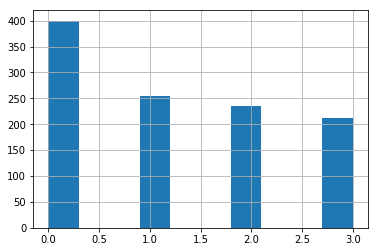

In [20]:
df=pd.read_csv('lemon_lesson/train_images.csv')
d=df['class_num'].hist().get_figure()
# 图像分类竞赛常见难点
# 类别不均衡
# one-shot和few-shot分类
# 细粒度分类

图像标准化与归一化，最常见的图像预处理方式有两种，一种是图标标准化处理，将数据按照比例缩放，使之落入一个特定的区间中，将数据通过去均值，实现中心化。第二种是数据归一化，将数据统一映射到0-1区间中
它的作用
1. 有利于初始化的进行
2. 避免给梯度数值更新带来数值问题
3. 有利于学习率数值的调整
4. 加快寻找最优解速度

In [21]:
# 定义数据预处理

data_transforms = T.Compose([
    T.Resize(size=(224, 224)),
    T.RandomHorizontalFlip(1),
    T.RandomVerticalFlip(1),
    T.Transpose(),    # HWC -> CHW
    T.Normalize(
        mean=[0, 0, 0],        # 归一化
        std=[255, 255, 255],
        to_rgb=True)    
])

In [22]:
## 数据集划分

train_images = pd.read_csv('lemon_lesson/train_images.csv', usecols=['id','class_num'])

# 划分训练集和校验集
all_size = len(train_images)
print(all_size)
train_size = int(all_size * 0.8)
train_image_path_list = train_images[:train_size]
val_image_path_list = train_images[train_size:]

print(len(train_image_path_list))
print(len(val_image_path_list))


1102
881
221


In [23]:
# 构建Dataset
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, train_list, val_list, mode='train'):
        """
        步骤二：实现构造函数，定义数据读取方式
        """
        super(MyDataset, self).__init__()
        self.data = []
        # 借助pandas读取csv文件
        self.train_images = train_list
        self.test_images = val_list
        if mode == 'train':
            # 读train_images.csv中的数据
            for row in self.train_images.itertuples():
                self.data.append(['train_images/'+getattr(row, 'id'), getattr(row, 'class_num')])
        else:
            # 读test_images.csv中的数据
            for row in self.test_images.itertuples():
                self.data.append(['train_images/'+getattr(row, 'id'), getattr(row, 'class_num')])

    def load_img(self, image_path):
        # 实际使用时使用Pillow相关库进行图片读取即可，这里我们对数据先做个模拟
        image = Image.open(image_path).convert('RGB')

        return image

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        image = self.load_img(self.data[index][0])
        label = self.data[index][1]

        return data_transforms(image), np.array(label, dtype='int64')

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)


In [25]:
# 定义数据loader
#train_loader
train_dataset = MyDataset(train_list=train_image_path_list, val_list=val_image_path_list, mode='train')
train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), batch_size=128, shuffle=True, num_workers=0)

#val_loader
val_dataset =MyDataset(train_list=train_image_path_list, val_list=val_image_path_list, mode='test')
val_loader = paddle.io.DataLoader(val_dataset, places=paddle.CPUPlace(), batch_size=128, shuffle=True, num_workers=0)

In [26]:
print('=============train dataset=============')
for image, label in train_dataset:
    print('image shape: {}, label: {}'.format(image.shape, label))
    break

for batch_id, data in enumerate(train_loader()):
    x_data = data[0]
    y_data = data[1]
    print(x_data)
    print(y_data)
    break

=============train dataset=============
image shape: (3, 224, 224), label: 0
Tensor(shape=[128, 3, 224, 224], dtype=float32, place=CPUPlace, stop_gradient=True,
       [[[[0.10980392, 0.10196079, 0.10588235, ..., 0.10588235, 0.11372549, 0.14117648],
          [0.11372549, 0.10980392, 0.10196079, ..., 0.11372549, 0.14509805, 0.16470589],
          [0.14901961, 0.11764706, 0.10196079, ..., 0.15686275, 0.23137255, 0.25098041],
          ...,
          [0.50588238, 0.50588238, 0.50588238, ..., 0.85882354, 0.85882354, 0.85882354],
          [0.50196081, 0.50196081, 0.50196081, ..., 0.85490197, 0.85490197, 0.85490197],
          [0.49803922, 0.49803922, 0.49803922, ..., 0.85098040, 0.85098040, 0.85098040]],

         [[0.06666667, 0.05882353, 0.06274510, ..., 0.08627451, 0.10196079, 0.13333334],
          [0.07450981, 0.07058824, 0.06274510, ..., 0.09803922, 0.13725491, 0.15686275],
          [0.11764706, 0.08627451, 0.07058824, ..., 0.14901961, 0.22745098, 0.25098041],
          ...,
      

In [5]:
## 选择自己的baseline
理想情况中，模型越大拟合能力越强。图像尺寸越大，保留的信息也越多，在实际情况中模型越复杂训练
时间越长，图像越长尺寸越大训练时间也越长

比赛开始有限使用最简单的resnet，快速跑完整个训练和预测流程，分类模型的选择需要根据任务复杂度来
进行选择，并不是精度越高的模型月适合参加比赛

在实际的比赛中可以逐步增加尺寸，在64-64的尺寸下让模型收敛，进而将模型放到128-128的尺寸爱训练

在选择的过程中baseline应该遵循几点原则
1. 复杂度地，代码结构简单
2. loss收敛正确，metric出现提升
3. 迭代快速，没有很fancy的模型结构、loss function或者图像预处理方法之类的
4. 需要编写正确并简单的测试脚本，能够提交submission之后获得正确的分数

id           train_0000.jpg
class_num                 0
Name: 0, dtype: object


In [27]:
# Sequential形式组网
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=4):
        super(MyNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=2, padding = 3)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3),  stride=1, padding = 1)
        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=128, kernel_size=(3,3),  stride=2, padding = 1)
        self.conv4 = paddle.nn.Conv2D(in_channels=128, out_channels=256, kernel_size=(3,3),  stride=2, padding = 1)
        self.conv5 = paddle.nn.Conv2D(in_channels=256, out_channels=512, kernel_size=(3,3),  stride=2, padding = 1)
        # # self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        # self.conv3 = paddle.nn.Conv2D(in_channels=448, out_channels=448, kernel_size=(3,3), stride=2, padding = 0)

        # self.conv4 = paddle.nn.Conv2D(in_channels=448, out_channels=448, kernel_size=(3,3), stride=2, padding = 1)

        self.flatten = paddle.nn.Flatten()
        self.linear1 = paddle.nn.Linear(in_features=25088, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)
        # # print(x.shape)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        # x = self.conv4(x)
        # x = F.relu(x)
        # # print(x.shape)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

model = paddle.Model(MyNet())
model.summary((1, 3, 224, 224))

[1, 64, 56, 56]
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-21     [[1, 3, 224, 224]]   [1, 64, 112, 112]        9,472     
  MaxPool2D-5   [[1, 64, 112, 112]]    [1, 64, 56, 56]           0       
   Conv2D-22     [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,928     
   Conv2D-23     [[1, 64, 56, 56]]     [1, 128, 28, 28]       73,856     
   Conv2D-24     [[1, 128, 28, 28]]    [1, 256, 14, 14]       295,168    
   Conv2D-25     [[1, 256, 14, 14]]     [1, 512, 7, 7]       1,180,160   
  Flatten-59      [[1, 512, 7, 7]]        [1, 25088]             0       
   Linear-7         [[1, 25088]]           [1, 64]           1,605,696   
   Linear-8          [[1, 64]]              [1, 4]              260      
Total params: 3,201,540
Trainable params: 3,201,540
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB):

{'total_params': 3201540, 'trainable_params': 3201540}

In [28]:
# 注意过程中特征图的计算
# 定义优化器
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
model.prepare(
    optim,
    paddle.nn.CrossEntropyLoss(),
    Accuracy()
    )

from visualdl import LogReader, LogWriter

args={
    'logdir':'./vdl',
    'file_name':'vdlrecords.model.log',
    'iters':0,
}

# 配置visualdl
write = LogWriter(logdir=args['logdir'], file_name=args['file_name'])
#iters 初始化为0
iters = args['iters'] 

#自定义Callback
class Callbk(paddle.callbacks.Callback):
    def __init__(self, write, iters=0):
        self.write = write
        self.iters = iters

    def on_train_batch_end(self, step, logs):

        self.iters += 1

        #记录loss
        self.write.add_scalar(tag="loss",step=self.iters,value=logs['loss'][0])
        #记录 accuracy
        self.write.add_scalar(tag="acc",step=self.iters,value=logs['acc'])

`./vdl/vdlrecords.model.log` is exists, VisualDL will add logs to it.


In [29]:
# 模型训练与评估
model.fit(train_loader,
        val_loader,
        log_freq=1,
        epochs=15,
        callbacks=Callbk(write=write, iters=iters),
        verbose=1, 
        )


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/15
[128, 64, 56, 56]
step 1/7 [===>..........................] - loss: 1.4849 - acc: 0.2266 - ETA: 7s - 1s/step[128, 64, 56, 56]
step 2/7 [=======>......................] - loss: 6.7525 - acc: 0.2930 - ETA: 6s - 1s/step[128, 64, 56, 56]
step 3/7 [===========>..................] - loss: 1.8031 - acc: 0.2708 - ETA: 4s - 1s/step[128, 64, 56, 56]
step 4/7 [================>.............] - loss: 1.3808 - acc: 0.2480 - ETA: 3s - 1s/step[128, 64, 56, 56]
step 5/7 [====================>.........] - loss: 1.2969 - acc: 0.2750 - ETA: 2s - 1s/step[128, 64, 56, 56]
step 6/7 [========================>.....] - loss: 1.2021 - acc: 0.3164 - ETA: 1s - 1s/step[113, 64, 56, 56]
step 7/7 [==============================] - loss: 1.1513 - acc: 0.3360 - 1s/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.

In [33]:
result = model.evaluate(val_loader,batch_size=32,log_freq=1, verbose=1, num_workers=0, callbacks=None)
print(result)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
[128, 64, 56, 56]
step 1/2 [==============>...............] - loss: 0.0984 - acc: 0.9688 - ETA: 1s - 1s/step[93, 64, 56, 56]
step 2/2 [==============================] - loss: 0.3313 - acc: 0.9502 - 1s/step          
Eval samples: 221
{'loss': [0.33130556], 'acc': 0.9502262443438914}
